# Regresión Lineal sobre dataset de tweets
Este notebook reproduce la carga y preprocesamiento del notebook de regresión logística, pero entrena un modelo de regresión lineal sobre la variable objetivo `tipo` codificada numéricamente. Esto es con fines didácticos (comparar enfoques).

In [4]:
# Importar librerías necesarias
import pandas as pd
pd.options.mode.chained_assignment = None
import re
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/matias/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/matias/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Cargar datos (mismas rutas que el notebook de regresión logística)
datos_validacion = pd.read_csv("data/twitter_validation.csv", header=None)
datos_entrenamiento = pd.read_csv("data/twitter_training.csv", header=None)
datos_validacion.columns = ['id', 'informacion', 'tipo', 'texto']
datos_entrenamiento.columns = ['id', 'informacion', 'tipo', 'texto']
# Preprocesamiento de texto: minusculas y limpieza similar a Logistic notebook
datos_entrenamiento['minusculas'] = datos_entrenamiento.texto.str.lower()
datos_entrenamiento['minusculas'] = [str(dato) for dato in datos_entrenamiento.minusculas]
datos_entrenamiento['minusculas'] = datos_entrenamiento.minusculas.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x))
datos_validacion['minusculas'] = datos_validacion.texto.str.lower()
datos_validacion['minusculas'] = [str(dato) for dato in datos_validacion.minusculas]
datos_validacion['minusculas'] = datos_validacion.minusculas.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x))
# Mostrar una vista rápida
datos_entrenamiento.head()

,id,informacion,tipo,texto,minusculas
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,i am coming to the borders and i will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting on borderlands 2 and i will murder ...


## Vectorización y reducción de dimensionalidad

Usamos CountVectorizer con tokenización por NLTK (igual que en el notebook de Logistic). Para que LinearRegression funcione bien con alta dimensionalidad, aplicamos TruncatedSVD (PCA para matrices dispersas) y escalamos.

In [6]:
# Definir vectorizador (Bag of Words) y transformar
stop_words = nltk.corpus.stopwords.words('english')
vectorizer = CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words, ngram_range=(1,2))
X_counts = vectorizer.fit_transform(datos_entrenamiento.minusculas)
X_val_counts = vectorizer.transform(datos_validacion.minusculas)
print('Dimensiones BOW train:', X_counts.shape)
# Reducir dimensionalidad para hacer factible la regresión lineal
n_components = 200  # asunción razonable; ajustar según tamaño de vocabulario
svd = TruncatedSVD(n_components=min(n_components, X_counts.shape[1]-1), random_state=0)
X_reduced = svd.fit_transform(X_counts)
X_val_reduced = svd.transform(X_val_counts)
print('Dimensiones reducidas train:', X_reduced.shape)
# Preparar target: codificar 'tipo' a valores numéricos para regresión
le = LabelEncoder()
y = le.fit_transform(datos_entrenamiento['tipo'])
y_val = le.transform(datos_validacion['tipo'])

/home/matias/Escritorio/Inteligencia-Artificial/venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/matias/Escritorio/Inteligencia-Artificial/venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'m", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


Dimensiones BOW train: (74682, 309655)
Dimensiones reducidas train: (74682, 200)
Dimensiones reducidas train: (74682, 200)


## División de conjuntos, entrenamiento y evaluación

Dividimos el conjunto de entrenamiento en train/test para evaluar rendimiento, entrenamos un LinearRegression y calculamos MSE y R2. También evaluamos sobre el conjunto de validación original.

In [7]:
# Split interno del conjunto de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=0)
# Escalado (opcional pero recomendado)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
X_val_s = scaler.transform(X_val_reduced)
# Entrenar LinearRegression
lr = LinearRegression()
lr.fit(X_train_s, y_train)
# Predicciones
pred_test = lr.predict(X_test_s)
pred_val = lr.predict(X_val_s)
# Métricas: MSE y R2 (para regresión continua)
mse_test = mean_squared_error(y_test, pred_test)
r2_test = r2_score(y_test, pred_test)
mse_val = mean_squared_error(y_val, pred_val)
r2_val = r2_score(y_val, pred_val)
print(f'MSE test: {mse_test:.4f}, R2 test: {r2_test:.4f}')
print(f'MSE validación: {mse_val:.4f}, R2 validación: {r2_val:.4f}')

MSE test: 0.9861, R2 test: 0.1362
MSE validación: 0.9230, R2 validación: 0.1760


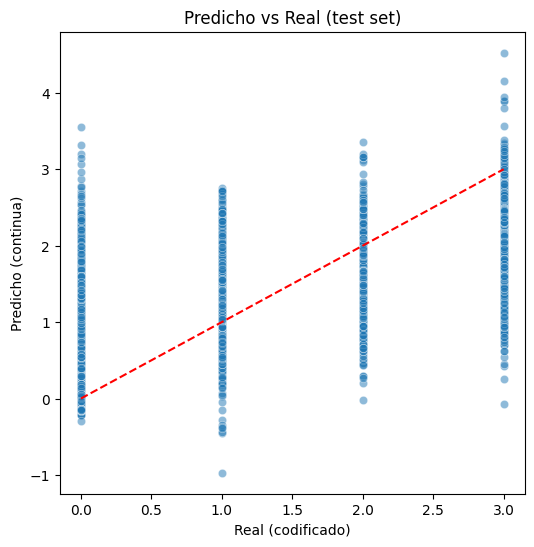

In [8]:
# Graficar predicho vs real (test)
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=pred_test, alpha=0.5)
plt.xlabel('Real (codificado)')
plt.ylabel('Predicho (continua)')
plt.title('Predicho vs Real (test set)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()
# Nota: los valores predichos son continuos; para comparar con clasificación se pueden redondear o transformar.

## Conclusión y siguientes pasos

- Este enfoque usa regresión lineal sobre etiquetas numéricas codificadas; es una demostración y no sustituye a modelos de clasificación para tareas de tipo `tipo` (categorías).
- Siguientes pasos: usar regresión logística multiclase (ya en el otro notebook), o modelos lineales con regularización (Ridge/Lasso), o modelos basados en árboles para comparación.